<a href="https://colab.research.google.com/github/thanh1605/-6-/blob/main/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/timeseries/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/timeseries/test.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [30]:
df_saturday = df[df['Publication_Day'] == 'Saturday'].copy()

df_sat = df_test[df_test['Publication_Day'] == 'Saturday'].copy()


df_saturday.head()
df_saturday.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103505 entries, 1 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           103505 non-null  int64  
 1   Podcast_Name                 103505 non-null  object 
 2   Episode_Title                103505 non-null  object 
 3   Episode_Length_minutes       91442 non-null   float64
 4   Genre                        103505 non-null  object 
 5   Host_Popularity_percentage   103505 non-null  float64
 6   Publication_Day              103505 non-null  object 
 7   Publication_Time             103505 non-null  object 
 8   Guest_Popularity_percentage  82283 non-null   float64
 9   Number_of_Ads                103505 non-null  float64
 10  Episode_Sentiment            103505 non-null  object 
 11  Listening_Time_minutes       103505 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 10.3+ MB


In [21]:
df_saturday.isna().sum()

,0
id,0
Podcast_Name,0
Episode_Title,0
Episode_Length_minutes,12063
Genre,0
Host_Popularity_percentage,0
Publication_Day,0
Publication_Time,0
Guest_Popularity_percentage,21222
Number_of_Ads,0


In [40]:
# Lấy chuỗi thời gian giả lập: dùng chỉ số làm thời gian và Listening_Time_minutes làm giá trị
target_series = df_saturday['Listening_Time_minutes'].reset_index(drop=True)
target_series = target_series.dropna()

# Kiểm tra một vài giá trị đầu tiên
target_series.head()



,Listening_Time_minutes
0,74.06554
1,15.12164
2,39.36483
3,17.94199
4,88.65718


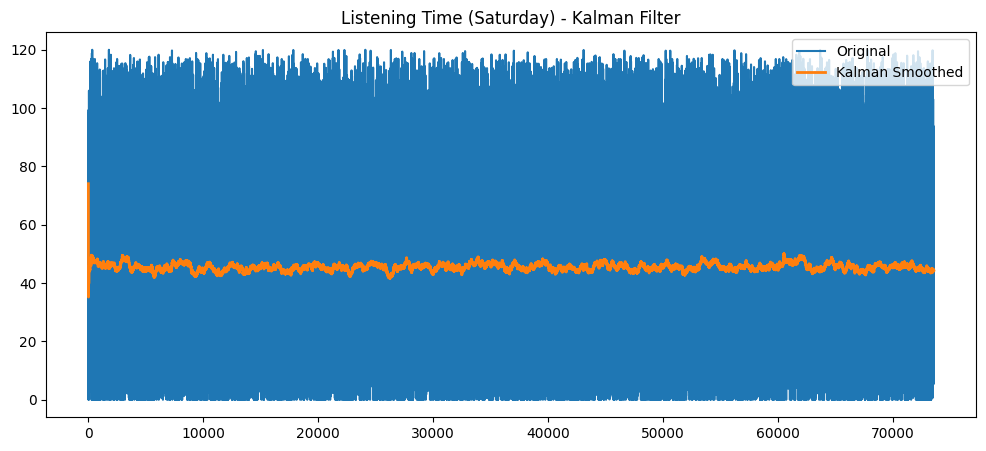

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simple_kalman_filter(z, Q=1e-5, R=1.0):
    n = len(z)
    xhat = np.zeros(n)      # a posteri estimate of x
    P = np.zeros(n)         # a posteri error estimate
    xhatminus = np.zeros(n) # a priori estimate of x
    Pminus = np.zeros(n)    # a priori error estimate
    K = np.zeros(n)         # gain or blending factor

    # Initial guess
    xhat[0] = z[0]
    P[0] = 1.0

    for k in range(1, n):
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + Q

        K[k] = Pminus[k] / (Pminus[k] + R)
        xhat[k] = xhatminus[k] + K[k] * (z[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]

    return xhat

# Ví dụ áp dụng cho chuỗi target_series
filtered = simple_kalman_filter(target_series.values)
smoothed_series = pd.Series(filtered, index=target_series.index)

# Plot để so sánh
plt.figure(figsize=(12,5))
plt.plot(target_series, label='Original')
plt.plot(smoothed_series, label='Kalman Smoothed', linewidth=2)
plt.title('Listening Time (Saturday) - Kalman Filter')
plt.legend()
plt.show()


In [45]:
!pip install statsmodels

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE AR: 1.0183313885951273
RMSE MA: 0.9783629311069378
RMSE ARIMA: 1.8263060994856264


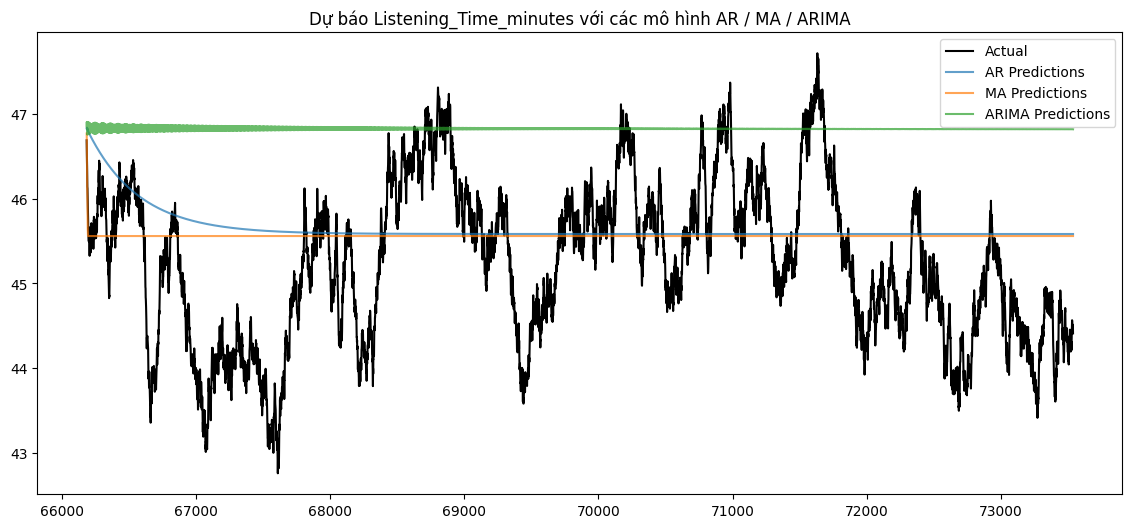

In [46]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Chia train/test: 90% train, 10% test
train_size = int(len(smoothed_series) * 0.9)
train, test = smoothed_series[:train_size], smoothed_series[train_size:]

# 1. Mô hình AR
ar_model = AutoReg(train, lags=20).fit()
ar_preds = ar_model.predict(start=len(train), end=len(train)+len(test)-1)

# 2. Mô hình MA (ARIMA(0,0,q))
ma_model = ARIMA(train, order=(0, 0, 10)).fit()
ma_preds = ma_model.forecast(steps=len(test))

# 3. Mô hình ARIMA (tùy chọn cấu hình)
arima_model = ARIMA(train, order=(5, 0, 5)).fit()
arima_preds = arima_model.forecast(steps=len(test))

# Đánh giá
print("RMSE AR:", np.sqrt(mean_squared_error(test, ar_preds)))
print("RMSE MA:", np.sqrt(mean_squared_error(test, ma_preds)))
print("RMSE ARIMA:", np.sqrt(mean_squared_error(test, arima_preds)))

# Vẽ biểu đồ
plt.figure(figsize=(14,6))
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, ar_preds, label='AR Predictions', alpha=0.7)
plt.plot(test.index, ma_preds, label='MA Predictions', alpha=0.7)
plt.plot(test.index, arima_preds, label='ARIMA Predictions', alpha=0.7)
plt.title("Dự báo Listening_Time_minutes với các mô hình AR / MA / ARIMA")
plt.legend()
plt.show()
